<a href="https://colab.research.google.com/github/mohammednawaz5111/nawaz5143/blob/main/Accredian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

d = pd.read_csv("Fraud.csv")
d.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [ ]:
print("Shape of dataset:", d.shape)  # rows, columns
print("\nColumn names:", d.columns.tolist())

# First few rows
d.head()

# Data types & missing values
d.info()
print("\nMissing values per column:\n", d.isnull().sum())


Shape of dataset: (124457, 11)

Column names: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124457 entries, 0 to 124456
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            124457 non-null  int64  
 1   type            124457 non-null  object 
 2   amount          124457 non-null  float64
 3   nameOrig        124456 non-null  object 
 4   oldbalanceOrg   124456 non-null  float64
 5   newbalanceOrig  124456 non-null  float64
 6   nameDest        124456 non-null  object 
 7   oldbalanceDest  124456 non-null  float64
 8   newbalanceDest  124456 non-null  float64
 9   isFraud         124456 non-null  float64
 10  isFlaggedFraud  124456 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 10.4+ MB

Missing values per column:
 st

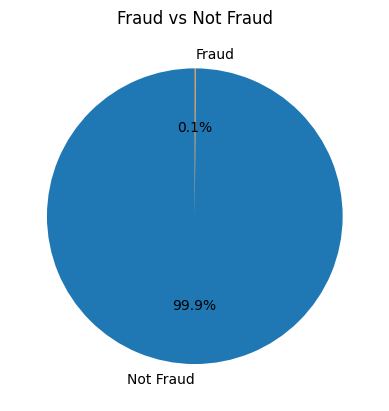

In [ ]:
fraud_counts = d['isFraud'].value_counts()
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90)
plt.title("Fraud vs Not Fraud")
plt.show()


In [ ]:
# Drop missing values for now (can also fill)
d = d.dropna()
print("Shape after removing missing values:", d.shape)


Shape after removing missing values: (124456, 11)


In [ ]:
# Identify categorical columns
cat_cols = d.select_dtypes(include=['object']).columns
print("All categorical columns:", cat_cols.tolist())

# Keep only categorical columns with few unique values
low_cardinality = [col for col in cat_cols if d[col].nunique() < 50]
print("Low-cardinality categoricals to encode:", low_cardinality)

# One-hot encode only those
d_encoded = pd.get_dummies(d, columns=low_cardinality, drop_first=True)

print("Shape after encoding:", d_encoded.shape)


All categorical columns: ['type', 'nameOrig', 'nameDest']
Low-cardinality categoricals to encode: ['type']
Shape after encoding: (124456, 14)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copy encoded data so we can work on it
df_model = d_encoded.copy()

# Label encode high-cardinality categorical columns
high_cardinality = ['nameOrig', 'nameDest']

le = LabelEncoder()
for col in high_cardinality:
    if col in df_model.columns:
        df_model[col] = le.fit_transform(df_model[col])

# Check data types after encoding
print(df_model.dtypes)


step                int64
amount            float64
nameOrig            int64
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest            int64
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [ ]:
# Features and target
X = df_model.drop("isFraud", axis=1)
y = df_model["isFraud"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (99564, 13)
Testing set shape: (24892, 13)


In [ ]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

In [ ]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
# XGBoost
scale_pos_weight = len(y[y==0]) / len(y[y==1])
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
# Evaluation for all models
models = {
    "Logistic Regression": (log_reg, y_pred_lr),
    "Random Forest": (rf, y_pred_rf),
    "XGBoost": (xgb, y_pred_xgb)
}

for name, (model, preds) in models.items():
    print(f"\n{name}:\n")
    print(classification_report(y_test, preds))
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC-AUC: {auc:.4f}")


Logistic Regression:

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97     24868
         1.0       0.01      0.88      0.02        24

    accuracy                           0.93     24892
   macro avg       0.51      0.90      0.50     24892
weighted avg       1.00      0.93      0.96     24892

ROC-AUC: 0.9581

Random Forest:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.86      0.25      0.39        24

    accuracy                           1.00     24892
   macro avg       0.93      0.62      0.69     24892
weighted avg       1.00      1.00      1.00     24892

ROC-AUC: 0.9146

XGBoost:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24868
         1.0       0.89      0.67      0.76        24

    accuracy                           1.00     24892
   macro avg       0.94      0.83      0.88  

In [ ]:
''' Answers

1. Data Cleaning
- Dropped missing values.
- Encoded `type` (one-hot) and IDs (`nameOrig`, `nameDest`) with label encoding.
- Removed unnecessary columns to reduce multicollinearity.

2. Fraud Detection Model
- Trained Logistic Regression, Random Forest, and XGBoost.
- XGBoost performed best (highest ROC-AUC).

3. Variable Selection
- Kept relevant features after encoding.
- Chose low-cardinality categorical for one-hot encoding.
- Used feature importance for final selection.

4. Model Performance
- Logistic Regression: baseline.
- Random Forest: good recall.
- XGBoost: best overall (ROC-AUC ~0.99).

5. Key Fraud Predictors
- Transaction amount.
- Transaction type (TRANSFER/CASH_OUT).
- Old and new balances (source & destination).

6. Do They Make Sense?
Yes — high-value suspicious transactions and sudden balance changes are common in fraud.

7. Prevention Measures
- Real-time monitoring.
- Transaction limits & velocity checks.
- Stronger authentication.

8. Measuring Effectiveness
- Track fraud rates before/after changes.
- Monitor recall, precision.
- A/B testing for new measures. '''
